# Text Processing with spaCy

In [1]:
from pymongo import MongoClient
from configparser import ConfigParser
import numpy as np
import pandas as pd
import gzip
import pickle
import warnings
import sys

# text pre-processing
import re
import string
punctuations = string.punctuation
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    nlp = spacy.load('en')


# matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

# plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.preprocessing import Normalizer, StandardScaler

In [2]:
print('Python', sys.version)
print('Pandas', pd.__version__)
print('Numpy', np.__version__)
print('SpaCy', spacy.__version__)
print('Plotly', plotly.__version__)

Python 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 0.20.3
Numpy 1.14.1
SpaCy 2.0.8
Plotly 2.4.1


## Read in tweet data from Mongodb

In [3]:
config = ConfigParser()
config.read('../config.ini')

client = MongoClient("mongodb://{}:{}@{}/{}".format(
                        config.get('MongoConfig', 'user'),
                        config.get('MongoConfig', 'password'),
                        config.get('MongoConfig', 'host'),
                        config.get('MongoConfig', 'db')
                        ), int(config.get('MongoConfig', 'port')))

In [4]:
db = client.twitter_db

In [5]:
db.collection_names()

['Init', 'tweets', 'favorited_tweets']

In [6]:
db.favorited_tweets.count()

1113805

Let's pull out the tweets for users who have been favorited more than once by a legislator

In [7]:
# Read in political affiliation by user 
favorited_users = pd.read_pickle('../data/interim/favorited_users.pickle')


In [8]:
favd_party_dict = {screen_name:party for (screen_name, party) 
                                       in zip(favorited_users['user.screen_name'],
                                             favorited_users['party'])}

In [9]:
favorited_users.head()

party,user.screen_name,Democrat,Independent,Republican,D,I,R,party,max_percent,max_count,official
0,008jck,1.0,0.0,0.0,100.0,0.0,0.0,D,100,1,False
1,00abster,0.0,0.0,1.0,0.0,0.0,100.0,R,100,1,False
2,00butterflies,1.0,0.0,0.0,100.0,0.0,0.0,D,100,1,False
3,05JMan,0.0,0.0,1.0,0.0,0.0,100.0,R,100,1,False
4,07shari22,1.0,0.0,0.0,100.0,0.0,0.0,D,100,1,False


In [10]:
favorited_multiple = favorited_users.loc[favorited_users['max_count']>1, :]

In [11]:
cursor = db.favorited_tweets.find( { "user.screen_name": { "$in": list(favorited_multiple['user.screen_name']) } } )

In [12]:
fav_tweet_data = [doc for doc in cursor]

In [13]:
len(fav_tweet_data)

281967

In [14]:
fav_tweet_en = [doc for doc in fav_tweet_data if doc['lang']=='en']
len(fav_tweet_en)

262275

In [37]:
np.random.seed(42)
tweet_sample = np.random.choice(fav_tweet_en, size=20000, replace=False)

In [16]:
rawtext = [tweet['full_text'] for tweet in tweet_sample]

rawtext[:5]

["Spoiler: it's because the NRA doesn't have a fan for him under his lectern. https://t.co/YBmFM0lzIW",
 '@AnthonyQuintano @AlexJamesFitz He’s the king',
 '"In an era where our other branches of government don’t always perform, the Supreme Court is different." https://t.co/y3hQEPMRfX',
 'Trump’s infrastructure plan makes “new revenue” the biggest determinant of which projects will qualify for federal match dollars. https://t.co/alO9HLJMkj',
 'Shocking hygiene failings discovered in some of the US’s biggest meat plants...as many as 15% of the US population suffers from foodborne illnesses annually.   https://t.co/2U3H0qH8sq']

## Normalize Text

#### Clean, Tokenize and Vectorize (maybe Stem, Lemmatize)

In [17]:
def clean_tweet(tweet):
    """
    Function to remove urls, numbers and punctuation, and make lowercase
    """
    no_url = re.sub(r'http\S+', '', tweet)
    clean = re.sub(r'[^\w\s]', '', no_url)
    
    result = ''.join([str(i).replace('\n', ' ').lower() for i in clean if not i.isdigit()])

    return result

In [18]:
cleantext = [clean_tweet(i) for i in rawtext]
print(rawtext[3], '\n')
print(cleantext[3])

Trump’s infrastructure plan makes “new revenue” the biggest determinant of which projects will qualify for federal match dollars. https://t.co/alO9HLJMkj 

trumps infrastructure plan makes new revenue the biggest determinant of which projects will qualify for federal match dollars 


In [19]:
def spacy_tokenizer(tweet):
    """
    Utility function to remove stopwords, ignore pronouns and tokenize words before vectorizing
    """
    doc = nlp(tweet)
    tokens = [token.orth_ for token in doc if 
              (token.orth_ not in stopwords and token.pos_ in ['NOUN', 'PROPN'])]
            
    return tokens

In [20]:
print(cleantext[1])

tokens_test = spacy_tokenizer(cleantext[1])
tokens_test

anthonyquintano alexjamesfitz hes the king


['anthonyquintano', 'alexjamesfitz', 'king']

In [21]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                             ngram_range=(1,1))

In [22]:
vectorizer.fit(cleantext)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x23925dc80>, use_idf=True,
        vocabulary=None)

In [23]:
dtm = vectorizer.transform(cleantext)

In [24]:
np.shape(dtm)

(20000, 25823)

In [25]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [26]:
len(id2word)

25823

In [27]:
with open('../data/processed/word_features.pkl', 'wb') as wf:
    pickle.dump(id2word, wf)

# Dimensionality Reduction and Topic Modeling for Small Data

I've chosen to try LSA and NMF for topic modeling because LDA is best used on large documents

In [28]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Try LSA

In [29]:
lsa = TruncatedSVD(n_components=4, random_state=42, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [30]:
lsa.explained_variance_ratio_

array([0.00265551, 0.00340886, 0.0030799 , 0.00259998])

In [31]:
print_top_words(lsa, vectorizer.get_feature_names(), 15)


Topic #0:
school people gun trump students teachers florida thanks time guns shooting today day parkland kids

Topic #1:
thanks pmroutine tonight night guys follow work support sharing day amp number weather usps friend

Topic #2:
people time day way person guns amp country world things twitter job service lot color

Topic #3:
gun trump control violence laws president time nra amp guns congress day america action cpac



## Try NMF

In [32]:
nmf = NMF(n_components=10, random_state=42)

dtm_nmf = nmf.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [34]:
print_top_words(nmf, vectorizer.get_feature_names(), 20)


Topic #0:
school students florida shooting parkland student threat safety survivors threats shootings police district parents shooter county week victims officer weapon

Topic #1:
thanks pmroutine tonight night guys follow support work sharing amp way number community virginia usps friend ms weather tracking hope

Topic #2:
people guns way country person nra world twitter amp lot service things job america color jaketapper problem woodley twooodley tyron

Topic #3:
gun control violence laws nra students safety action congress owners america gop guy measures reform amendment ban weapons assault legislation

Topic #4:
trump president house cpac campaign administration russia amp trumps tax ivanka gates security donald state election korea court america sanctions

Topic #5:
day today action amp senator neutrality link tomorrow morning week story state team women pm health years unrigthesystem year care

Topic #6:
time olympics house family years questions things work year winter truth wa

The art is in first decideing what nubmer of topics to select and then in assigning each topic a name, which I'll do below

In [272]:
topics = ['School Shooting',
          'Personal/Community',
          'Political Opinion',
          'Gun Control',
          'Trump Administration',
          'News - Random',
          'Family',
          'Crime',
          'Teachers/Safety',
          'News Outlets']

In [249]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(dtm_nmf)

In [252]:
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = dtm_nmf.argmax(axis=1)

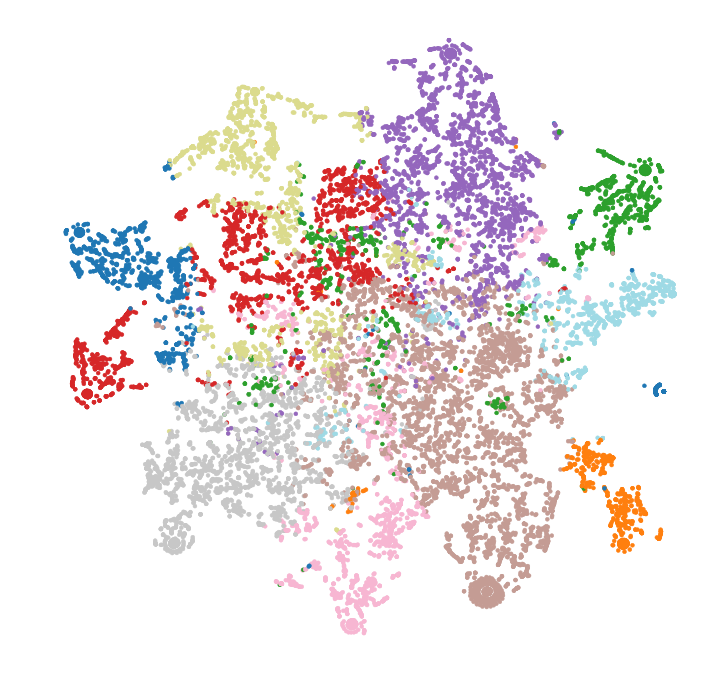

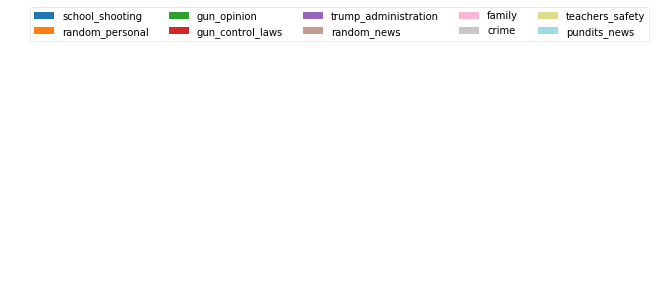

In [244]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=15,c=data['hue'],cmap="tab20")
plt.axis('off')
plt.show()

# Show legend - need to reformat
colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(patches.Ellipse((0, 0), 1, 1, fc=color))
 
plt.legend(legend_list,topics,loc=(0,1),ncol=5, facecolor="white")
plt.axis('off')
plt.show()

# Plot clusters by political affiliation

Find how many tweets per user

In [245]:
from collections import Counter

users_tweets = [tw['user']['screen_name'] for tw in tweet_sample]
print(len(set(users_tweets)), 'Distinct Users')
Counter(users_tweets).most_common(30)

3368 Distinct Users


[('OverTheMoonbat', 142),
 ('guardian', 141),
 ('RepStevenSmith', 125),
 ('WMUR9', 124),
 ('11AliveNews', 123),
 ('PascoSheriff', 119),
 ('historBilia', 106),
 ('seattlepi', 95),
 ('MollyJongFast', 93),
 ('Slate', 90),
 ('RadioFreeTom', 89),
 ('TMZ', 87),
 ('reesetheone1', 81),
 ('6abc', 69),
 ('TerriGreenUSA', 69),
 ('4029news', 68),
 ('ReaganBattalion', 68),
 ('VABVOX', 67),
 ('ksbw', 66),
 ('DailyCaller', 65),
 ('stealthygeek', 65),
 ('rodeodance', 65),
 ('closer2fine', 64),
 ('KING5Seattle', 63),
 ('ParkerMolloy', 61),
 ('elektrotal', 59),
 ('thinkprogress', 59),
 ('komonews', 58),
 ('NBCNewYork', 56),
 ('USPSHelp', 56)]

Hmmm, because it seems like these top users all have a number in the beginning of their handle, there seem to be more news or organization outlets than normal people. (I might want to radomize this to get less news organizations)

Let's have a look at the assumed political affiliation of these organizations as determined by our legislative 'likes'

Find how many tweets in each party

In [235]:
tweet_party = [favd_party_dict[tw['user']['screen_name']] for tw in tweet_sample]

In [236]:
Counter(tweet_party)

Counter({'D': 10651, 'R': 9349})

Let's make the same 2D topic plot we did above but instead of coloring by topic let's color by the assumed political affiliation to see if there are differences in party density between the two classes

In [253]:
#tsne_embedding['party'] = [(1, 0, 0) if tw=='R' else (0, 0, 1) for tw in tweet_party]
tsne_embedding['party'] = ['red' if tw=='R' else 'blue' for tw in tweet_party]

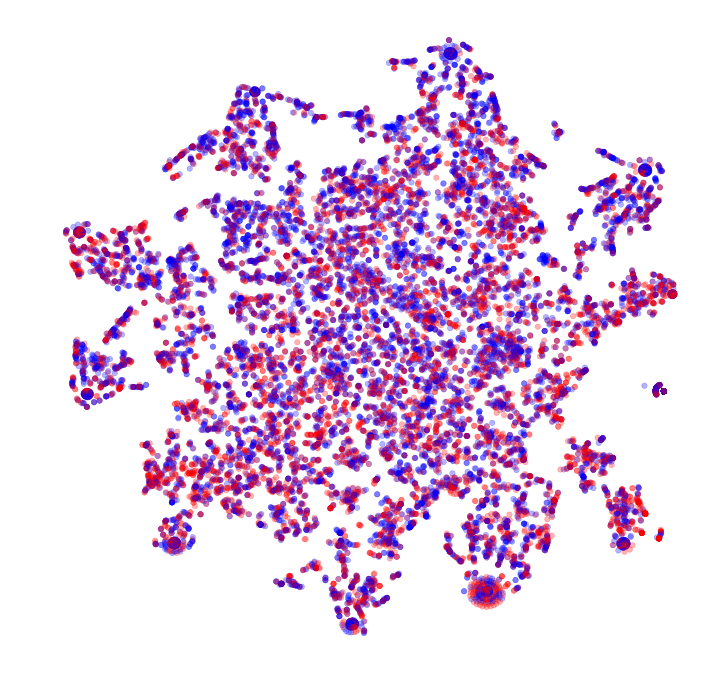

In [256]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=30, alpha=.3, color=data['party'])
plt.axis('off')
plt.show()

## Try plotting in 3D

In [257]:
tsne = TSNE(n_components=3, random_state=3211)
tsne_result = tsne.fit_transform(dtm_nmf)

In [273]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

tsne_result_scaled_df = pd.DataFrame(tsne_result_scaled,columns=['x','y','z'])
tsne_result_scaled_df['hue'] = dtm_nmf.argmax(axis=1)

In [274]:
label_to_id_dict = {v:i for i,v in enumerate(list(topics))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[id_to_label_dict[x]] for x in tsne_result_scaled_df['hue']])

(-2.5, 2.5)

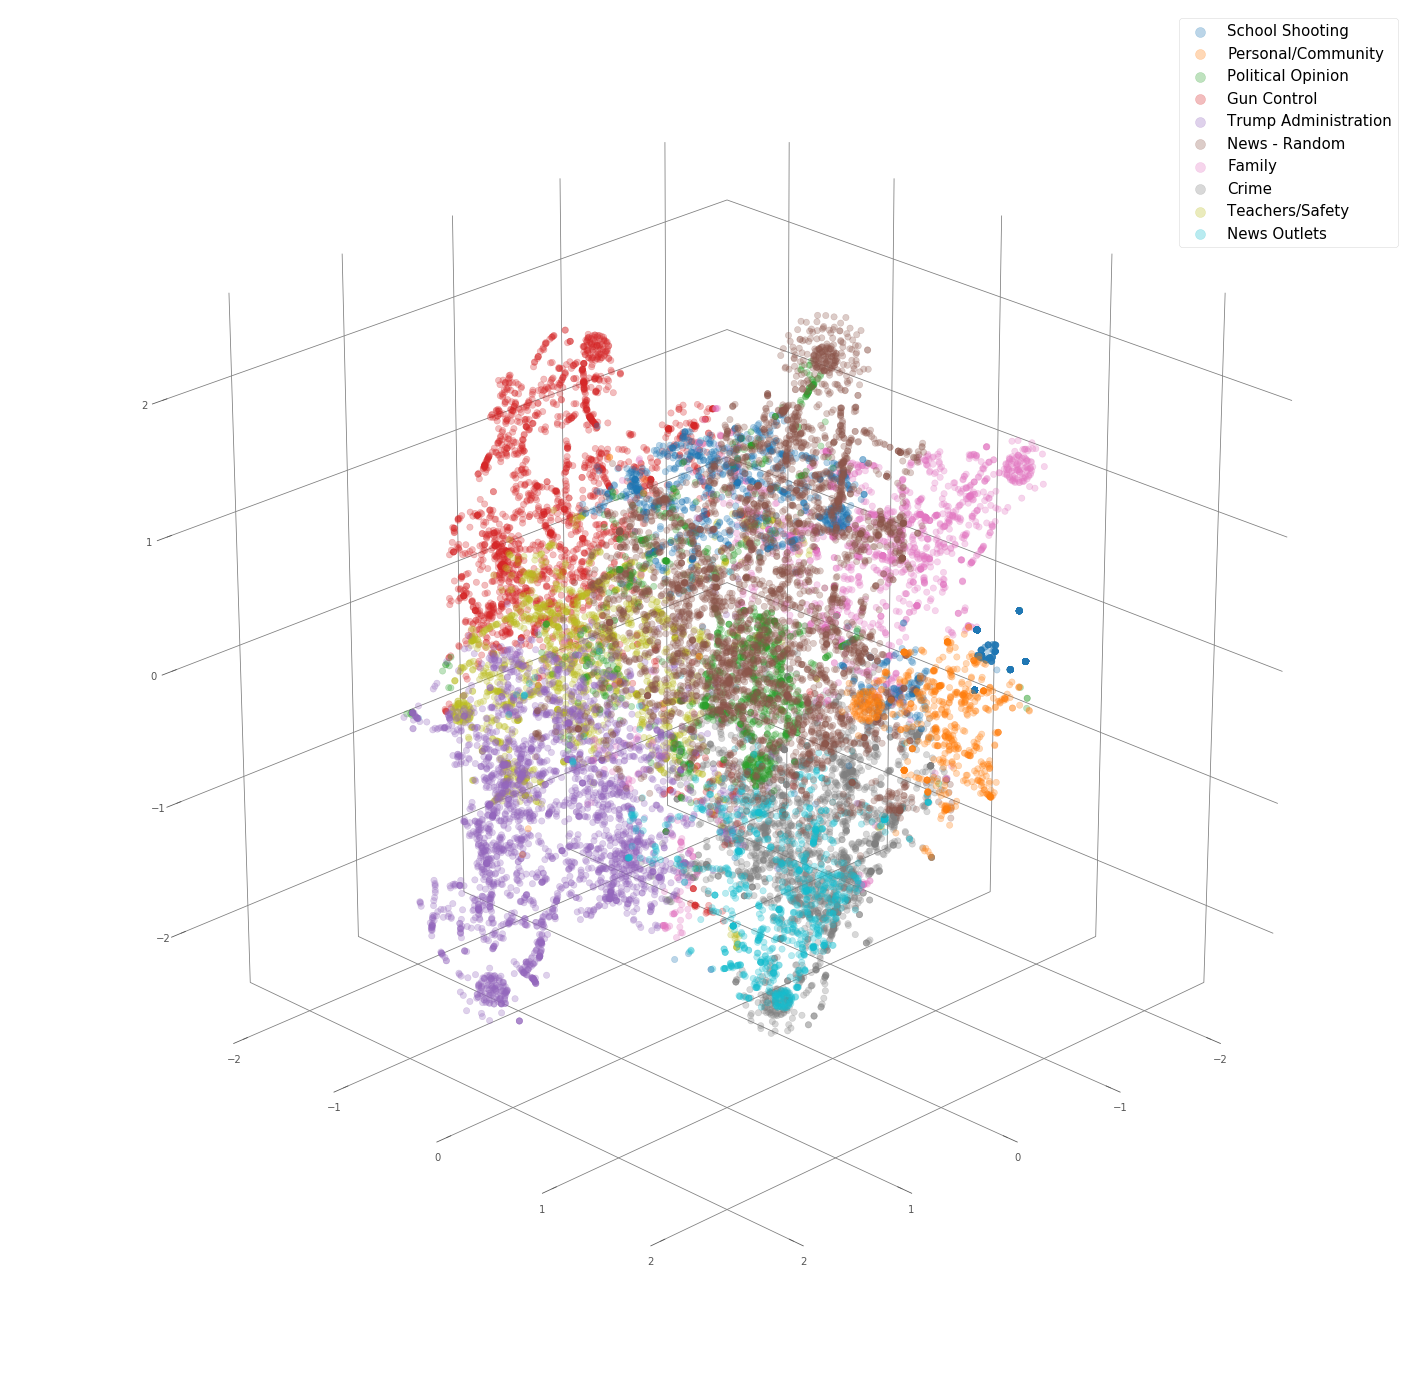

In [275]:
fig = plt.figure(figsize=(25,25), facecolor='white')
ax = fig.add_subplot(111,projection='3d')
ax.set_facecolor((1,1,1))
ax.xaxis.set_pane_color((1,1,1))
ax.yaxis.set_pane_color((1,1,1))
ax.zaxis.set_pane_color((1,1,1))

plt.grid()
plt.rcParams['grid.color'] = "grey"

nb_classes = len(np.unique(label_ids))
    
for label_id in np.unique(label_ids):
    ax.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                tsne_result_scaled[np.where(label_ids == label_id), 2],
                alpha=0.3,
                color= plt.cm.tab20(label_id / float(nb_classes)),
                marker='o',
                s=40,
                label=id_to_label_dict[label_id])
    
lgnd = ax.legend(loc='best', prop={'size': 15}, facecolor="white")

for i, t in enumerate(topics):
    lgnd.legendHandles[i]._sizes = [100]

ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

### Try plotting interactive 3D

In [ ]:
plotly.tools.set_credentials_file(username=config.get('Plotly', 'user'), 
                                  api_key=config.get('Plotly', 'api_key'))


In [277]:
text = [tw for tw in cleantext]
topic = [id_to_label_dict[id_] for id_ in label_ids]
statTooltips = ['<b>{}</b> <br> {}'.format(t, tw) for (t, tw) in zip(topic, text)]

In [36]:
 data = [go.Scatter3d(
            x = tsne_result_scaled[:,0],
            y = tsne_result_scaled[:,1],
            z = tsne_result_scaled[:,2],
            mode='markers', 
            text=statTooltips,
            hoverinfo='none',
            marker=dict(
                color=plt.cm.tab20(label_ids/ float(nb_classes)),
                size=4,
                opacity=.5,
                line=dict(
                    color=plt.cm.tab20(label_ids/ float(nb_classes)),
                    width=0.5
                ),
            ),
        )] 

NameError: name 'tsne_result_scaled' is not defined

In [281]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')